# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch - Now Using UA SWE Data 


This notebook is a slightly modified version of the protoype model provided to the Frosty Dawgs team, demonstrating an LSTM model to predict SWE on several Huc10 units in Skagit Basin.  It represents the starting point for the team's work and we thank the authors of the original prototype model.  

This notebook modifies the original noebook by chainging the data source to use a longer time series of data (UA data).  Additional modifications include: (1) adds a KGE goodness of fit metric, (2) adds ML Flow tracking capabilities and (3) normalizes the UA data prior to model training. 

First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
from snowML import data_utils as du

from torch import nn
#from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

##  Set the MLflow tracking server

Note: Assumes you have already started mlflow by opening a terminal withy mlflow installed and running mlflow uo

In [2]:
# Set our tracking server uri for logging
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"
mlflow.set_tracking_uri(tracking_uri)

# Create a new MLflow Experiment called "LSTM"
mlflow.set_experiment("ProtoType_Results")

<Experiment: artifact_location='s3://sues-test/199', creation_time=1740199897768, experiment_id='199', last_update_time=1740199897768, lifecycle_stage='active', name='ProtoType_Results', tags={}>

## Data Prepration 

In [3]:
# This function loads the model ready data for a given huc number

def get_dogs_data(huc_list, var_list):
    bucket_name = "snowml-model-ready"
    df_dict = {}  # Initialize dictionary
    for huc in huc_list: 
        file_name = f"model_ready_huc{huc}.csv"
        df = du.s3_to_df(file_name, bucket_name)
        df['day'] = pd.to_datetime(df['day'])
        df.set_index('day', inplace=True)  # Set 'day' as the index
        df = df[var_list]
        df_dict[huc] = df  # Store DataFrame in dictionary
    return df_dict


In [4]:
huc_list = [1711000504, 1711000505, 1711000506, 1711000507, 1711000508, 1711000509, 1711000511]
var_list = ["mean_pr", "mean_tair", "mean_swe"]
df_dict = get_dogs_data(huc_list, var_list)
# display an example 
df = df_dict[1711000506]
df.head(2)

,mean_pr,mean_tair,mean_swe
day,,,
1983-10-01,0.0,4.683,0.0
1983-10-02,0.0,5.416,0.0


In [5]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
    normalized_df = df.copy()

    for column in ["mean_pr", "mean_tair"]:
        column_mean = df[column].mean()
        column_std = df[column].std()
        normalized_df[column] = (df[column] - column_mean) / column_std

    return normalized_df

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [6]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :2].values  # Select first two columns
        target = dataset.iloc[i + lookback, -1:].values  # Selects the last column dynamically
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
def train_test_split(data, train_size_fraction):
    train_size_main = int(len(data) * train_size_fraction)
    test_size_main = len(data) - train_size_main
    train_main, test_main = data[:train_size_main], data[train_size_main:]
    return train_main, test_main, train_size_main, test_size_main

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting mean_swe values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [8]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. It also prints the Root Mean Square Error (RMSE) every 10 epochs.

In [9]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
	loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
	epoch_losses = []

	for epoch in  range(n_epochs):
		epoch_loss = 0.0
		model.train()
		for X_batch, y_batch in loader:
			y_pred = model(X_batch)
			loss = loss_fn(y_pred, y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		# Validation
		if epoch % 10 != 0:
			continue

		model.eval()

		with torch.no_grad():
			y_pred = model(X_train)
			train_rmse = np.sqrt(loss_fn(y_pred, y_train))
			print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}")

		epoch_losses.append(epoch_loss / len(loader))

	return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual mean_swe values.



In [10]:
def predict(data, model, X_train,X_test, lookback, train_size, huc_no, n_epochs):
    data = data.astype(object)
    with torch.no_grad():
        train_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        y_pred = model(X_train)
        print(y_pred.shape)
        y_pred_new = y_pred[:,  -1].unsqueeze(1)
        print(y_pred_new.shape)
        print(type(lookback),type(train_size))
        train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))  # Create figure explicitly
    ax.plot(data.index, data['mean_swe'], c='b', label='Actual')
    ax.plot(data.index, train_plot, c='r', label='Train Predictions')
    ax.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('mean_swe')
    ttl = f"UAData{n_epochs}_SWE_Post_Predictions_for_huc_{huc_no}"
    ax.set_title(ttl)
    plt.show()

    fig.savefig(f"{ttl}.png", bbox_inches='tight')
    mlflow.log_artifact(f"{ttl}.png")
    plt.close(fig)

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2). In addition, Kling-gupta-efficiency (KGE) added by the Frosty Dawgs team. 

In [11]:
def kling_gupta_efficiency(y_true, y_pred):
    r = np.corrcoef(y_true.ravel(), y_pred.ravel())[0, 1] # Correlation coefficient
    alpha = np.std(y_pred) / np.std(y_true)  # Variability ratio
    beta = np.mean(y_pred) / np.mean(y_true)  # Bias ratio
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    #print(f"r: {r}, alpha: {alpha}, beta: {beta}")
    return kge

In [12]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
    train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
    test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
    train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
    test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

    test_kge = kling_gupta_efficiency(y_test.numpy(), y_test_pred.numpy())  # Fixed function call
    train_kge = kling_gupta_efficiency(y_train.numpy(), y_train_pred.numpy())  # Fixed variable name

    return [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2, train_kge, test_kge]


In [13]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0759
Epoch 10: train RMSE 0.0341
Epoch 20: train RMSE 0.0243
Epoch 30: train RMSE 0.0187
Epoch 40: train RMSE 0.0184
Epoch 50: train RMSE 0.0169
Epoch 60: train RMSE 0.0203
Epoch 70: train RMSE 0.0153
Epoch 80: train RMSE 0.0134
Epoch 90: train RMSE 0.0110
Epoch 100: train RMSE 0.0122
Epoch 110: train RMSE 0.0169
Epoch 120: train RMSE 0.0117
Epoch 130: train RMSE 0.0101
Epoch 140: train RMSE 0.0110
Epoch 150: train RMSE 0.0087
Epoch 160: train RMSE 0.0083
Epoch 170: train RMSE 0.0101
Epoch 180: train RMSE 0.0096
Epoch 190: train RMSE 0.0094
Epoch 70: train RMSE 0.0069
Epoch 80: train RMSE 0.0075
Epoch 90: train RMSE 0.0076
Epoch 100: train RMSE 0.0075
Epoch 110: train RMSE 0.0069
Epoch 120: train RMSE 0.0085
Epoch 130: train RMSE 0.0062
Epoch 140: train RMSE 0.0080
Epoch 150: train RMSE 0.0071
Epoch 160: train RMSE 0.0087
Epoch 170: train RMSE 0.0095
Epoch 180: train RMSE 0.0071
Epo

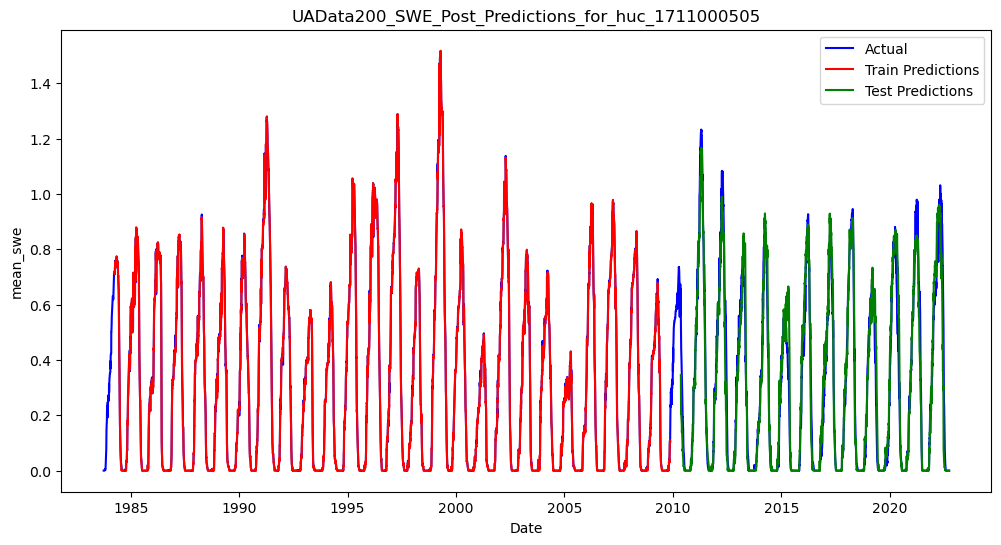

[2.5321571e-05, 0.0054528285, 0.0033616351, 0.04413428, 0.9997745156288147, 0.948071300983429, 0.9947243900276249, 0.972716965609655]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000025     1735.241664
1       180  snotel   test_mse  0.005453     1735.241664
2       180  snotel  train_mae  0.003362     1735.241664
3       180  snotel   test_mae  0.044134     1735.241664
4       180  snotel   train_r2  0.999775     1735.241664
5       180  snotel    test_r2  0.948071     1735.241664
6       180  snotel  train_kge  0.994724     1735.241664
7       180  snotel   test_kge  0.972717     1735.241664
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0292
Epoch 10: train RMSE 0.0192
Epoch 20: train RMSE 0.0140
Epoch 30: train RMSE 0.0141
Epoch 40: train RMSE 0.0104
Epoch 50: train RMSE 0.0103
Epoch 60: train RMSE 0.0092
Epoch 70: train RMSE 0.0093
Epoch 80: train RMSE 0.0099
Epoch 90: train RMS

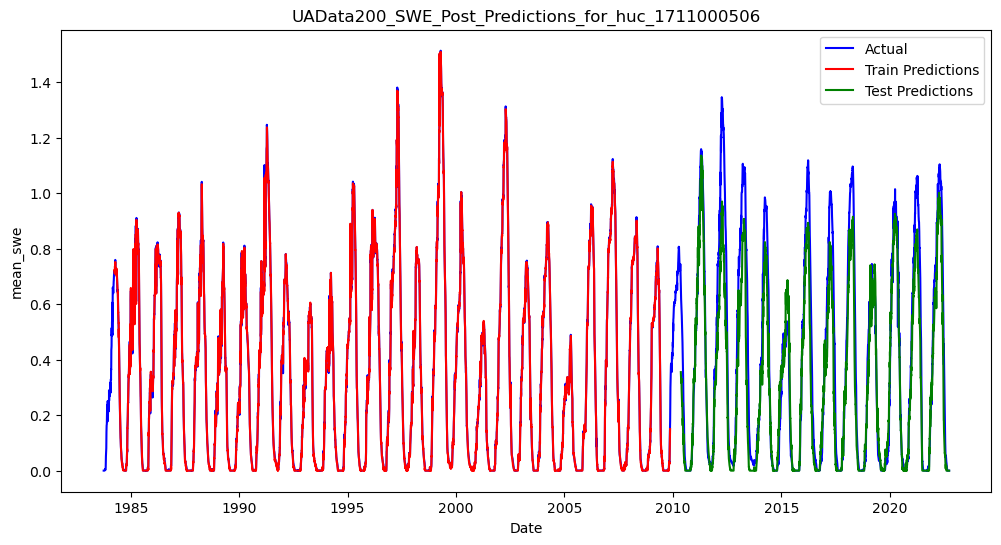

[3.8277572e-05, 0.017934948, 0.0043783872, 0.089735694, 0.9996622800827026, 0.8756468296051025, 0.9943306648763152, 0.7458449747602164]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000038     1731.873599
1       180  snotel   test_mse  0.017935     1731.873599
2       180  snotel  train_mae  0.004378     1731.873599
3       180  snotel   test_mae  0.089736     1731.873599
4       180  snotel   train_r2  0.999662     1731.873599
5       180  snotel    test_r2  0.875647     1731.873599
6       180  snotel  train_kge  0.994331     1731.873599
7       180  snotel   test_kge  0.745845     1731.873599
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0211
Epoch 10: train RMSE 0.0127
Epoch 20: train RMSE 0.0117
Epoch 30: train RMSE 0.0099
Epoch 40: train RMSE 0.0090
Epoch 50: train RMSE 0.0096
Epoch 60: train RMSE 0.0078
Epoch 70: train RMSE 0.0069
Epoch 80: train RMSE 0.0073
Epoch 90: train R

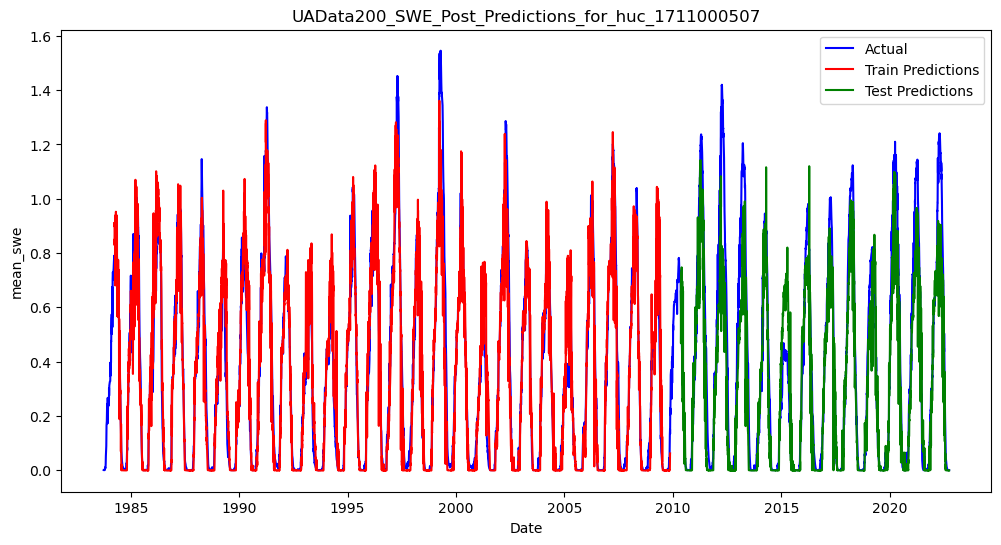

[0.012044244, 0.026879255, 0.065716155, 0.10471547, 0.8990486264228821, 0.8210777640342712, 0.9372624726157304, 0.7319981526753234]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.012044     1708.772903
1       180  snotel   test_mse  0.026879     1708.772903
2       180  snotel  train_mae  0.065716     1708.772903
3       180  snotel   test_mae  0.104715     1708.772903
4       180  snotel   train_r2  0.899049     1708.772903
5       180  snotel    test_r2  0.821078     1708.772903
6       180  snotel  train_kge  0.937262     1708.772903
7       180  snotel   test_kge  0.731998     1708.772903
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.1049
Epoch 10: train RMSE 0.1547
Epoch 20: train RMSE 0.1784
Epoch 30: train RMSE 0.1759
Epoch 40: train RMSE 0.1886
Epoch 50: train RMSE 0.1892
Epoch 60: train RMSE 0.1522
Epoch 70: train RMSE 0.1338
Epoch 80: train RMSE 0.1579
Epoch 90: train RMSE 

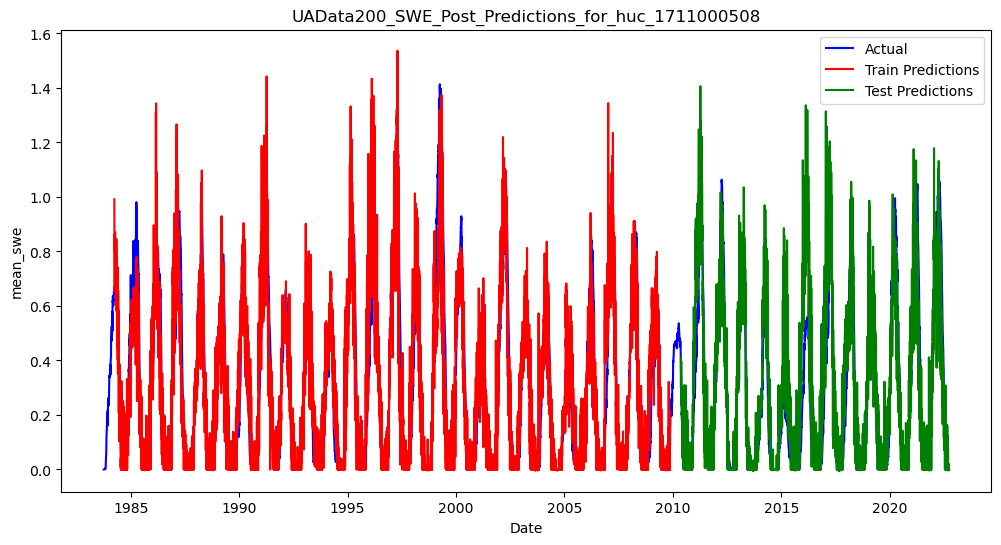

[0.02225153, 0.02749311, 0.100042365, 0.11090196, 0.764816164970398, 0.6962102651596069, 0.8619025322510341, 0.7911697494455734]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.022252     1719.230069
1       180  snotel   test_mse  0.027493     1719.230069
2       180  snotel  train_mae  0.100042     1719.230069
3       180  snotel   test_mae  0.110902     1719.230069
4       180  snotel   train_r2  0.764816     1719.230069
5       180  snotel    test_r2  0.696210     1719.230069
6       180  snotel  train_kge  0.861903     1719.230069
7       180  snotel   test_kge  0.791170     1719.230069
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.1027
Epoch 10: train RMSE 0.0971
Epoch 20: train RMSE 0.1085
Epoch 30: train RMSE 0.0873
Epoch 40: train RMSE 0.0911
Epoch 50: train RMSE 0.0830
Epoch 60: train RMSE 0.0917
Epoch 70: train RMSE 0.0958
Epoch 80: train RMSE 0.0865
Epoch 90: train RMSE 0.0

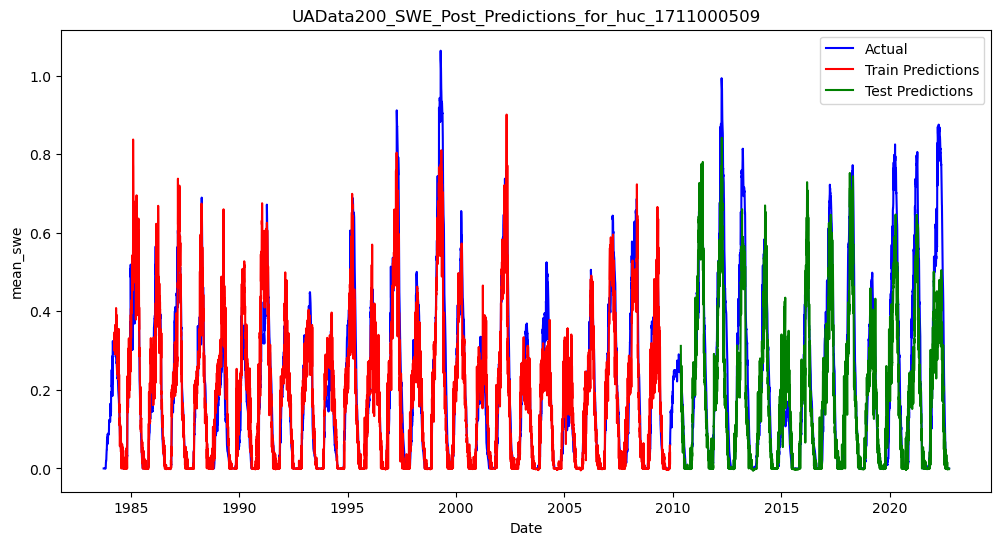

[0.0069097048, 0.016027361, 0.054331053, 0.08359096, 0.8205047845840454, 0.7498952150344849, 0.8695148550649152, 0.6623265476886593]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.006910     1682.935277
1       180  snotel   test_mse  0.016027     1682.935277
2       180  snotel  train_mae  0.054331     1682.935277
3       180  snotel   test_mae  0.083591     1682.935277
4       180  snotel   train_r2  0.820505     1682.935277
5       180  snotel    test_r2  0.749895     1682.935277
6       180  snotel  train_kge  0.869515     1682.935277
7       180  snotel   test_kge  0.662327     1682.935277
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train RMSE 0.0577
Epoch 10: train RMSE 0.0445
Epoch 20: train RMSE 0.0451
Epoch 30: train RMSE 0.0432
Epoch 40: train RMSE 0.0594
Epoch 50: train RMSE 0.0581
Epoch 60: train RMSE 0.0487
Epoch 70: train RMSE 0.0569
Epoch 80: train RMSE 0.0539
Epoch 90: train RMSE

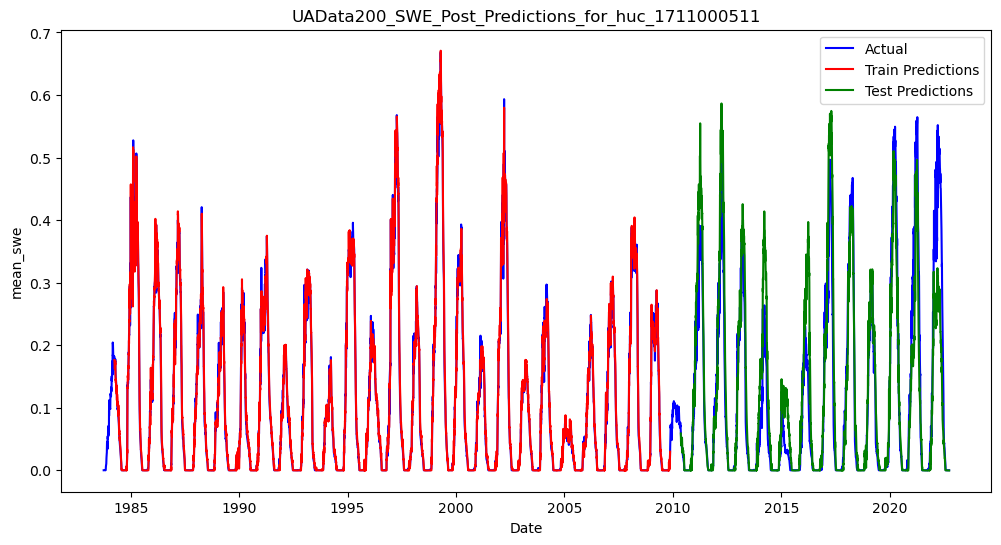

[7.552692e-05, 0.0039282744, 0.005665685, 0.036642138, 0.9954661726951599, 0.8270672559738159, 0.981159731992771, 0.8944715201483121]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000076     1676.942415
1       180  snotel   test_mse  0.003928     1676.942415
2       180  snotel  train_mae  0.005666     1676.942415
3       180  snotel   test_mae  0.036642     1676.942415
4       180  snotel   train_r2  0.995466     1676.942415
5       180  snotel    test_r2  0.827067     1676.942415
6       180  snotel  train_kge  0.981160     1676.942415
7       180  snotel   test_kge  0.894472     1676.942415
🏃 View run debonair-ape-13 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199/runs/81757efa26da4005ae1956876ea39a3b
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199


In [ ]:
# Define the hyperparameters
input_size=2
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 200
train_size_fraction = 0.67
lookback_values =  [180]


with mlflow.start_run():
    # log all the params
    mlflow.log_param("Training From", "Prototype Notebook")
    mlflow.log_param("Data Source", "UA SWE Data")
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_class", num_class)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_size_fraction", train_size_fraction)
    mlflow.log_param("lookback_values", lookback_values)
    mlflow.log_param("epochs", n_epochs) 

    model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
    optimizer_snotel = optim.Adam(model_snotel.parameters())
    loss_fn_snotel = nn.MSELoss()

    for huc_no in huc_list: 
        # Get the model ready data 
        data = df_dict[(huc_no)]
        data = z_score_normalize(data)
        print(f"NA datais {data.isna().sum()}")
        data = data.fillna(method='bfill')
        train_main, test_main, train_size_main, test_size_main = train_test_split(data, train_size_fraction)

        # Usage example
        lookback_values =  [180]
        results = []

        for lookback in lookback_values:
            print(f"\nLookback: {lookback}")
            start_time = time.time()

            # Snotel dataset
            X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
            X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)

            train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=n_epochs, batch_size=8) 
            predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main, huc_no, n_epochs)
            snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
            print(snotel_metrics)
            elapsed_time = time.time() - start_time

            results.append([lookback, 'snotel', 'train_mse', snotel_metrics[0], elapsed_time])
            results.append([lookback, 'snotel', 'test_mse', snotel_metrics[1], elapsed_time])
            results.append([lookback, 'snotel', 'train_mae', snotel_metrics[2], elapsed_time])
            results.append([lookback, 'snotel', 'test_mae', snotel_metrics[3], elapsed_time])
            results.append([lookback, 'snotel', 'train_r2', snotel_metrics[4], elapsed_time])
            results.append([lookback, 'snotel', 'test_r2', snotel_metrics[5], elapsed_time])
            results.append([lookback, 'snotel', 'train_kge', snotel_metrics[6], elapsed_time])
            results.append([lookback, 'snotel', 'test_kge', snotel_metrics[7], elapsed_time])

            
            mlflow.log_metric(f"{huc_no}_train_mse", snotel_metrics[0])
            mlflow.log_metric(f"{huc_no}_test_mse", snotel_metrics[1])
            mlflow.log_metric(f"{huc_no}_train_kge", snotel_metrics[6])
            mlflow.log_metric(f"{huc_no}_test_kge", snotel_metrics[7])



        # Create a DataFrame for the results
        df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])

        # Print the DataFrame
        print(df_results)